In [404]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)

In [6]:
library(tidyverse)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg38)
library(pheatmap)
library(TFBSTools)
library(BiocParallel)
library(purrr)
register(MulticoreParam(10))
set.seed(2019)

In [5]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/")

# chromVAR analysis 1 - chromVAR + Jaspar 2020 motifs
**Inputs**
1. *Peaks*: These are peaks centered at summit with uniform width of 500 bp as recommended by chromVAR. Files are under `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`. First 3 columns are standard bed, the 4th column is peak intensity as calculated from MACS2.
2. *Annovation*: Jaspar 2020 motifs

In [7]:
samplesheet <- read.csv('samplesheet2.csv', stringsAsFactors = F)

# Peaks
peak.file <- "/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed"
peaks <- getPeaks(peak.file, sort_peaks = T)

peaks <- resize(peaks, width = 500, fix = "center")

my_counts_matrix <- read.table("diffbind_consensu_min2overlap_readcounts.txt", header = T) %>% as.matrix

depth <- apply(my_counts_matrix, 2, sum)
colData <- column_to_rownames(samplesheet, 'SampleID')
colData <- add_column(colData, depth) # add read depth per sample

fragment_counts <- SummarizedExperiment(assays = list(counts = my_counts_matrix),
                                        rowRanges = peaks, colData = colData)

fragment_counts.addGC <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg38)

# each peak must have at least 10 reads across all 12 samples to be included
fragment_counts.filtered <- filterPeaks(fragment_counts.addGC, min_fragments_per_peak = 10, 
                                       non_overlapping = T)

#### Annotations

Get JASPAR2020 motifs. Then construct a motif - gene_name lookup table. In addition, add columns to indicate if a motif is a TF or hit TF.

In [185]:
# New method: use downloaded JASPAR2020
jaspar_2020 <- readJASPARMatrix("JASPAR2020_combined_matrices_20191030.txt", matrixClass = "PFM")

#120 hit list
hitlist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/HS_td-VStd+_td-VSdox120.csv', header = F, stringsAsFactors = F) %>% pull
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)
hitlist <- c(hitlist, c('NEUROG1', 'NEUROG2')) # adding NERUOG1/2 to hit list

# construct base motif_lookup table
motif_lookup <- TFBSTools::name(jaspar_2020) %>% 
                data.frame(stringsAsFactors = F) %>% 
                rownames_to_column("motif") %>% 
                mutate(gene_name=str_extract(`.`, "[a-zA-Z:0-9\\-]+")) %>%
                select(motif, gene_name)

# function to check if a tf name is in the substring of jaspar name
mystrfunc <- function(stringA, target) {
    # string A is a possible gene name, scalar
    # target is a vector of proper gene names
    # match if any target is a substring in string A, if so return True
    stringA <- rep(stringA, length(target))
    test <- unlist(map2(stringA, target, ~ str_detect(.x, .y)))
    return(any(test))
}

#motif_lookup <- motif_lookup  %>% mutate(is_hit = map(gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No"))) %>%
                 #mutate(is_tf = map(gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No"))) 

is_hit <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No")) %>% unlist
is_tf <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No")) %>% unlist

motif_lookup <- motif_lookup %>% add_column(is_hit = is_hit, is_tf = is_tf)

#### Deviations

In [188]:
# get motif matches with peaks
motif_ix <- matchMotifs(jaspar_2020, fragment_counts.filtered, genome = BSgenome.Hsapiens.UCSC.hg38)

# computing deviations
dev <- computeDeviations(object = fragment_counts.filtered, annotations = motif_ix)

In [263]:
# Add motif's gene names and whethere it's a hit / tf or not
# some motifs has 2 or 3 variants with the same gene name, thus taking the mean of all motif scores for the same gene
dev.scores <- deviationScores(dev) %>% 
                as.data.frame %>% 
                rownames_to_column('motif') %>% 
                left_join(motif_lookup, by = 'motif') %>%
                select(A1:is_tf) %>% 
                group_by(gene_name, is_hit, is_tf) %>% 
                summarise_all(mean) %>%
                ungroup()

In [264]:
dev.scores %>% filter(str_detect(gene_name, 'IN'))

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HINFP,No,No,-0.5231813,-0.8282186,-0.2087987,-0.9428153,-0.5757492,0.4029261,-1.8173974,0.292883849,0.6963859,-0.3519080,1.0831309,0.04676416
INSM1,Yes,Yes,-0.7307915,-0.3888077,-0.6474780,-0.2012271,0.8012730,-0.8055105,-0.8337466,0.003287291,0.2647908,-0.7116292,0.4566794,0.67134149


---

## Clustering based on correlation

In [24]:
sample_cor <- getSampleCorrelation(dev)

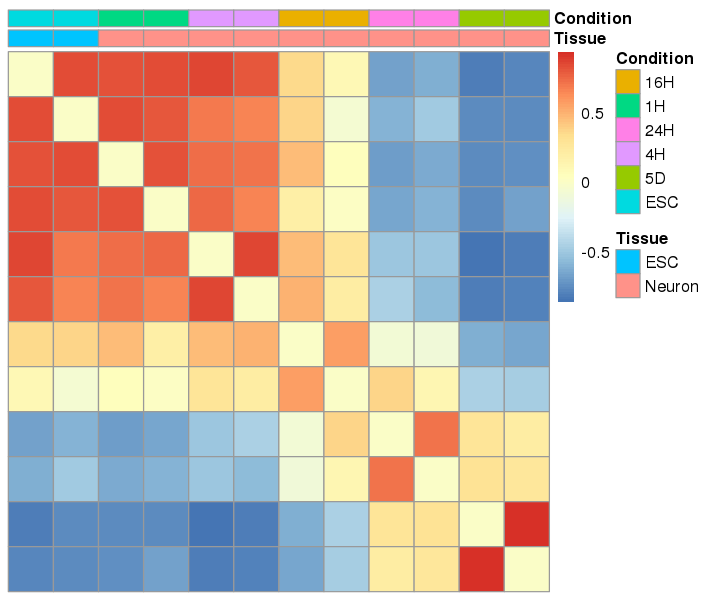

In [25]:
pheatmap(as.dist(sample_cor), annotation = data.frame(colData(dev)[,c(1,3)]), clustering_distance_rows = as.dist(1-sample_cor), clustering_distance_cols = as.dist(1-sample_cor),
        cluster_rows = F, show_rownames = T, cluster_cols = F, show_colnames = T)

In [265]:
dev.scores %>% filter(gene_name == 'ZBTB18')

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,Yes,Yes,-2.985783,-1.339436,-1.119262,-2.149746,-1.096181,0.81261,-0.004189217,0.3828894,0.5594746,0.9304151,1.28975,1.386024


## Hit TF motifs' accessibility

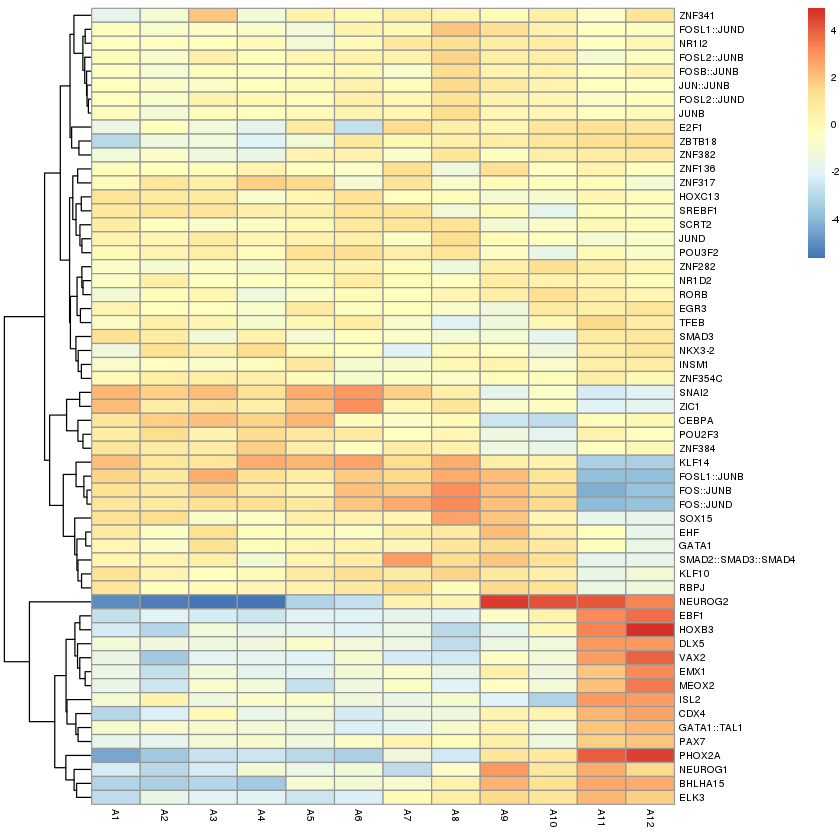

In [402]:
dev.scores %>% filter(is_hit == "Yes") %>% 
                select(gene_name, A1:A12) %>% 
                column_to_rownames('gene_name') %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, fontsize=6)

##### Heatmap for all TF (~1800) motif binding sites accessibility 

** cluster rows (TF motifs) by hits vs non hits **

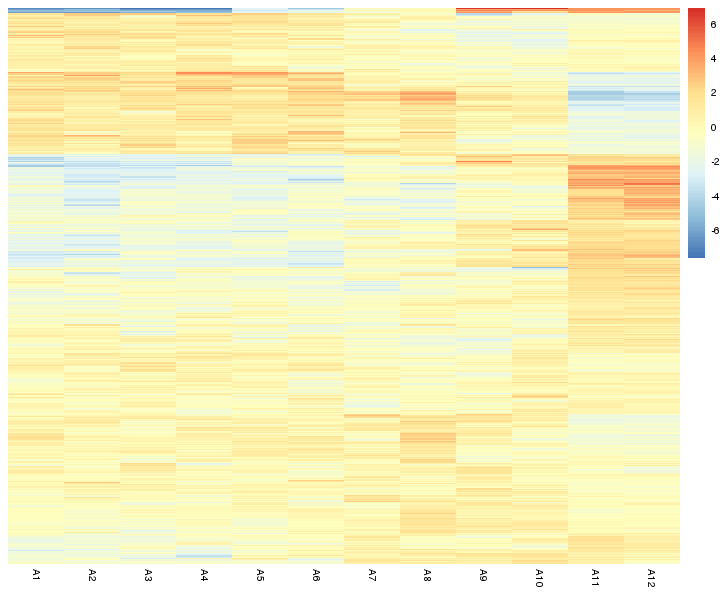

In [282]:
dev.scores %>%  filter(is_tf == "Yes") %>% select(gene_name, A1:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=0)

**ZBTB18 sequence logo**

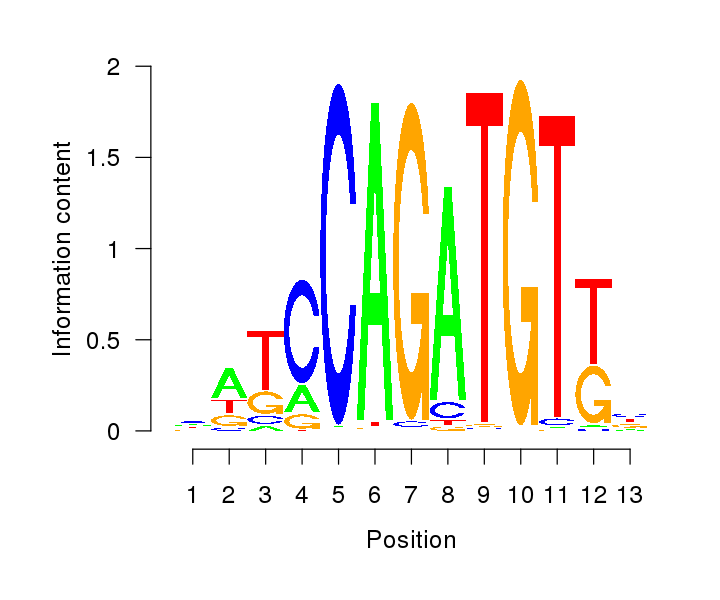

In [285]:
#sequence logo for ZBTB18
mx <- toPWM(Matrix(jaspar_2020)$ZBTB18, "prob" )
seqLogo::seqLogo(mx)

## Find TF targets

Use motifMatchr to match all promoter region first. Then intersect ATACseq peaks with promoter region (that are matched with a certain motif). The result is a list of peaks from ATACseq that belong to a list of genes' promoter region, with which the motif(TF) can bind to. In otherwords, given a TF motif, we now have a list of genes that have been assayed to show different binding accessibility to the TF motif. 

zbtb18 motif ID `MA0698.1`

##### Support functions for this section 


In [286]:
getSubjectGRanges <- function(feature.granges, matchMotifResult, motif_id) {
    # inputs:
    # feature.granges = GRange object of feature, e.g. promoter
    # matchMotifResult - matchMotifs result of feature region, and motifs
    # motif.db - motifs, such as jaspar 2018 motifs
    # hitgenelist - hit gene list, a vector
    # motif_lookup - motif look up dataframe, indicating whether a motif is hit or not, and gene name
    # outputs:
    # matched_features: the GRange object of features that match to the specified motif (motif_id)
    
    motif_matches_matrix <- motifMatches(matchMotifResult) # matrix of matching motifs and peak GRanges
    motif_match_per_feature_idx <- motif_matches_matrix[, motif_id] %>% as.matrix %>% which # row index of matched feature granges
    matched_features <- feature.granges[motif_match_per_feature_idx]
    return(matched_features) # return feature promoter (GRanges) that match to JASPAR motifs
}

In [589]:
findDeviationPerTarget <- function(devScore.peak, motif_ix, motif_id, feature_granges, min.overlap = 10, hitgenelist) {
    # inputs:
    # deviationResult: chromVar computed deviation
    # fragment.counts: RangedSummarizedExperiment from chromVAR, including filtered peaks and readcounts
    # subject.granges: GRange object that you want to intersect with. For example, Promoter ranges. Note, it should have gene_name or gene_id included in mcols
    # min.overlap: minimum overlap for GenomicRanges::findOverlaps method
    # output: 
    # deviation.score.per.target: given genomic feature region, e.g. promoter region that maps to ZBTB18 motif, chromVAR deviation results, and fragment counts, report the genes 
    # that are potential targets of the given motif (determined by subject.granges), and report deviation score.
    
    peak_idx <- which(motif_mx[, motif_id])  # indices of peaks that match a particular motif
    devScore.peak.motif <- devScore.peak[peak_idx] # deviation scores of peaks that match to a particular motif
    
    # find overlap between query (a motif matched peak set), and subject (such as promoters)
    hitTarget.overlap <- GenomicRanges::findOverlaps(query = devScore.peak.motif, subject = feature_granges, minoverlap = min.overlap, ignore.strand = T)
    
    # get gene_names from the feature granges
    gene_names <- feature_granges[subjectHits(hitTarget.overlap)] %>%
                    elementMetadata %>% 
                    as.data.frame %>% 
                    pull(gene_name)
    
    # concatenate overlap results (peaks that are within promoter or gene regions). 
    # Output dataframe includes peaks that are within genomic feature in subject.granges, and its annotation (gene_name)
    target_devScore.peak.motif <- devScore.peak.motif[queryHits(hitTarget.overlap)] %>% 
                                    mcols  %>% # deviation scores stored in mcols 
                                    as.data.frame %>% 
                                    add_column('gene_name' = gene_names) %>% 
                                    dplyr::select(A1:gene_name) %>% 
                                    filter(gene_name %in% hitgenelist) %>% 
                                    group_by(gene_name) %>% 
                                    summarise_all(sum) %>% 
                                    arrange(gene_name)
    return(target_devScore.peak.motif)
}

In [457]:
motif_mx <- motifMatches(motif_ix)

In [530]:
# get deviation score per peak
devScore.peak <- deviationScores(dev.peak)

# Above dataframe doesn't have peak coordinates. Thus get coordinates
devScore.peak <- rowRanges(motif_ix) %>% as.data.frame %>%
                        dplyr::select(seqnames, start, end) %>%
                        cbind(devScore.peak) %>%
                        makeGRangesFromDataFrame(keep.extra.columns = T)

In [591]:
findDeviationPerTarget(devScore.peak = devScore.peak, motif_ix = motif_ix, motif_id = "ZBTB18", feature_granges = promoter_region, min.overlap = 10, hitgenelist = hitlist)

gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASB1,-1.63224156,-0.7599316,0.2908151,-0.8157510,-1.2585020,-1.0960026,-0.37026791,-1.86743101,-0.7097542,-0.2080400,1.54124289,1.76254145
HOXC13,1.63134930,0.9069386,2.0865571,0.8908936,-1.1354783,0.7729794,1.56382233,0.96718139,-1.5241284,0.4728896,-0.80145212,-1.36366063
NEUROG3,-0.75294477,1.0974950,0.7820315,0.4006767,-0.1150740,-0.5666478,-1.63449446,0.09419121,0.6746069,-0.7506456,0.08550146,-0.03291909
SNAI2,-0.08862484,-0.3075732,-1.6112993,0.6526108,-0.7030391,0.7804442,-0.76934183,0.04049983,-0.2654365,-0.6334845,0.35055891,0.76553371
ZBTB18,-0.95362066,-1.4133651,-0.8003541,-1.1239297,-1.6975473,0.2970299,-0.08202638,1.26726877,1.3822240,-0.1556908,0.95921011,-0.61930786
ZNF136,-0.52890578,0.2324278,-0.1869049,-0.7233623,-0.9953801,0.1224864,0.72475364,-0.77551311,0.1066273,-0.9672570,0.30201341,0.78250685


##### 1 First load motifs and calculate peak deviation score

In [76]:
# use previous loaded jaspar_2020
# use previous calculated motif_ix

In [77]:
# calculate deviation scores for each peak
dev.peak <- computeDeviations(object = fragment_counts.filtered)

Annotations not provided, so chromVAR being run on individual peaks...


##### 2 Then get GRanges of the promoters that match interested TF motifs

In [542]:
# get annotated promoter region bed
promoter_region <- read.table("Protein_coding_gene_promoters_V2.bed", header = F, stringsAsFactors = F, 
                              col.names = c("seqname","start","end","gene_id","gene_name","strand")) %>% 
                                dplyr::select(seqname, start, end, strand, gene_id, gene_name)
# convert to GRanges object
promoter_region <- GenomicRanges::makeGRangesFromDataFrame(promoter_region, keep.extra.columns = T)

In [80]:
# match motifs with promoter region, results in a match matrix
match_promoter_motif <- matchMotifs(jaspar_2020, promoter_region, genome = BSgenome.Hsapiens.UCSC.hg38)

##### 3 Get motif list of interest.

*A list of TF motifs that are increasing accessibility at D5 vs ES:*

In [290]:
dev.scores %>%  filter(is_hit == "Yes") %>% dplyr::select(gene_name, A1:A2, A11:A12) %>% head

gene_name,A1,A2,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BHLHA15,-3.1753602,-3.2611520,2.5296884,2.481469327
CDX4,-3.0949635,-2.2426577,2.1761598,2.675535285
CEBPA,0.9338416,1.6840119,-0.2024688,-0.002317859
DLX5,-1.0202832,-1.2583087,2.8233549,2.865175207
E2F1,-1.4580818,-0.3459171,1.1487514,0.932599322
EBF1,-2.7420232,-2.1083591,3.1708995,3.686616397


In [291]:
# deviation scores for just 5D vs ES for hit TF motifs
dev.scores.ES_5D.hit <- dev.scores %>%  filter(is_hit == "Yes") %>% dplyr::select(gene_name, A1:A2, A11:A12)

# calculate mean difference between two time points
dev.ES.mean <- dev.scores.ES_5D.hit[,2:3] %>% apply(MARGIN = 1, mean)
dev.5D.mean <- dev.scores.ES_5D.hit[,4:5] %>% apply(MARGIN = 1, mean)
dev.5D_sub_ES <- dev.5D.mean - dev.ES.mean
dev.scores.ES_5D.hit <- dev.scores.ES_5D.hit %>% add_column("5D-ES"=dev.5D_sub_ES)

# select TF motifs that have increasing accessibility
TF <- dev.scores.ES_5D.hit %>% filter(`5D-ES` > 0) %>% pull(gene_name)
TF_motif_ids <- motif_lookup %>% filter(gene_name %in% TF) %>% pull(motif)

In [427]:
TF %>% length()
TF_motif_ids %>% length()

[1] 32

[1] 37

##### 4 For each interested TF motif, get its target gene's deviation score

In [294]:
target_genes <- list()

for (motif_id in TF_motif_ids) {
    promoter_GR <- getSubjectGRanges(promoter_region, match_promoter_motif, motif_id)
    target <- findDeviationPerTarget(dev.peak, fragment_counts.filtered, promoter_GR, min.overlap = 10, hitlist)
    target.ES.mean <- target %>% dplyr::select(A1,A2) %>% apply(1, mean)
    target.5D.mean <- target %>% dplyr::select(A11,A12) %>% apply(1, mean)
    target.5D_sub_ES <- target.5D.mean - target.ES.mean
    target <- target %>% add_column("5D_ES"=target.5D_sub_ES)
    target <- target %>% filter(`5D_ES` > 0)
    target_genes[[motif_lookup[motif_lookup$motif == motif_id,'gene_name']]] <- target
}

In [366]:
# expand list to dataframe
target_genes.df <- do.call(rbind,target_genes)
target_genes.df <- target_genes.df %>% rownames_to_column("TF") %>% mutate_at("TF", ~ str_remove(.x, "\\.[0-9]+$"))

In [367]:
target_genes.df %>% write.table("TF_target_interactions_all.csv", sep = ",", row.names = F, col.names = T, quote = F)

In [368]:
target_genes.df %>% dplyr::select(TF, gene_name, `5D_ES`) %>% write.table("TF_target_interactions.csv", sep = ",", row.names = F, col.names = T, quote = F)

##### 5 Cross reference ATAC seq TF-Target interactions in RNA seq

In [369]:
# get RNA temporal profile
rna_temporal <- read.table("../RNAseq_WT_temporal.csv", sep = ",", stringsAsFactors = F, header=T)

In [370]:
tf_target_intera <- read.table("TF_target_interactions.csv", sep = ",", header = T, stringsAsFactors = F)

In [371]:
out.nodes <- tf_target_intera %>% pull(TF) %>% unique
in.nodes <- tf_target_intera %>% pull(gene_name) %>% unique
all.nodes <- c(out.nodes, in.nodes) %>% unique

In [372]:
tf_target_intera %>% left_join(rna_temporal[,2:3], by = c("TF" = "gene_name")) %>%
                        rename("X5D_ES"="devS.dif", "expr.flag"="source.temporal") %>%
                        left_join(rna_temporal[,2:3], by = c("gene_name" = "gene_name")) %>%
                        rename("expr.flag"="target.temporal") %>%
                        write.table("TF_target_interactions_with_RNAseq.csv", sep = ",", row.names = F, col.names = T, quote = F)

---

---

 example of zbtb18

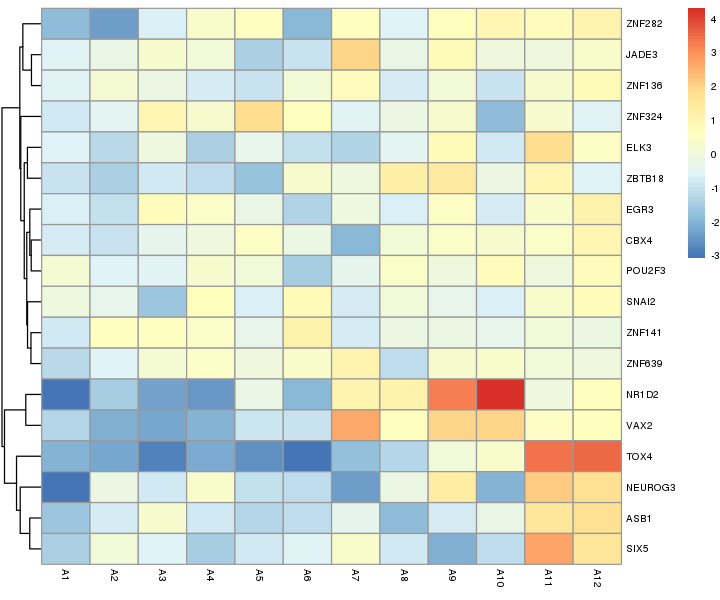

In [408]:
target_genes$ZBTB18 %>% dplyr::select(gene_name, A1:A12) %>% group_by(gene_name) %>% summarise_all(sum) %>%
                        arrange(gene_name) %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=20)

In [123]:
target_genes$ZBTB18

gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,5D_ES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASB1,-1.9592469,-0.790397832,0.01396296,-0.74472122,-1.58930340,-1.4722890,-0.25490863,-1.9557599867,-0.50409707,-0.07395578,1.82727477,1.6841125,3.130515960
CBX4,-0.8542060,-0.824157838,-0.34023230,0.15930855,0.46052267,-0.1953741,-2.23106842,0.0822370192,0.71818172,0.16987227,0.33040342,0.8071105,1.407938888
EGR3,-1.0440287,-0.862423699,0.84786695,0.22074818,-0.18931437,-1.5112052,0.01986702,-1.2831192384,0.73568623,-1.05500295,0.53789188,1.1841048,1.814224554
ELK3,-0.8010713,-1.292018113,-0.14966110,-1.12594038,-0.04793381,-0.8425278,-1.07529995,-0.3183867099,0.71271260,-0.83565218,1.81693918,0.2418177,2.075923158
JADE3,-0.1000897,-0.004461541,0.28186208,0.05914897,-1.15457570,-0.8166714,1.91285872,-0.1303332234,0.28422944,-0.06159769,-0.02553125,0.3044522,0.191736090
NEUROG3,-3.1793183,0.178909197,-0.42557994,0.46242473,-0.64173170,-0.7382782,-2.49544909,-0.2953105230,1.39723919,-2.41361162,1.74383480,1.5867035,3.165473727
NR1D2,-3.2069529,-1.479766974,-2.45469872,-2.62470486,-0.34651441,-2.0879666,0.83045509,0.6155900847,3.50732807,3.96244252,0.07069976,0.7107794,2.734099561
SIX5,-1.4224897,0.141161292,-0.73567207,-1.53839218,-0.74924383,-0.4538154,0.14468458,-1.0842415234,-1.48600702,-0.76860476,2.59224593,1.4099016,2.641737972
SNAI2,-0.1373908,-0.365331473,-1.28960414,0.70079925,-0.67621721,0.8769753,-0.97784940,-0.0884652497,-0.34926280,-0.87609638,0.33849166,0.8745496,0.857881754


In [169]:
motif_lookup[which(motif_lookup %>% pull(gene_name) %>% str_detect("NEU")),]

,motif,gene_name,is_hit,is_tf
,<chr>,<chr>,<chr>,<chr>
130,MA0668.1,NEUROD2,No,Yes
131,MA0669.1,NEUROG2,No,Yes
390,MA1109.1,NEUROD1,No,Yes


In [171]:
dev.scores %>% filter(gene_name == "NEUROG2")

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0669.1,-2.927776,-4.872323,-3.301028,-3.906312,-3.868612,-1.627386,0.5470498,0.7853264,3.412203,2.425836,2.948557,1.619116,NEUROG2,No,Yes


### Statistics  on motif data

In [384]:
# total TFs
jaspar_2020 %>% names %>% str_extract("[a-zA-Z0-9]+") %>% unique %>% length

[1] 567

In [385]:
# total motifs
jaspar_2020 %>% length

[1] 639

In [386]:
# number of motifs that are in hit list
motif_lookup %>% filter(is_hit == "Yes") %>% pull(gene_name) %>% unique %>% length

[1] 57